## Spark introduction


# Pré-requis

Dans une infrastructure BIG DATA, on couple souvent Spark et HDFS : Spark pour le traitement des données et HDFS pour le stockage de données. Généralement les workers Spark implémentent aussi la fonctionnalité datanode pour permettre d'exécuter le traitement au plus proche des données. 

Dans l'environnement Docker, nous utiliserons notre cluster HDFS abordé précédemment pour effectuer des traitements via un cluster Spark.

Notre cluster Spark sera constitué de 2 workers avec 1 cpu et 1Go de RAM pour ne pas trop charger votre machine.






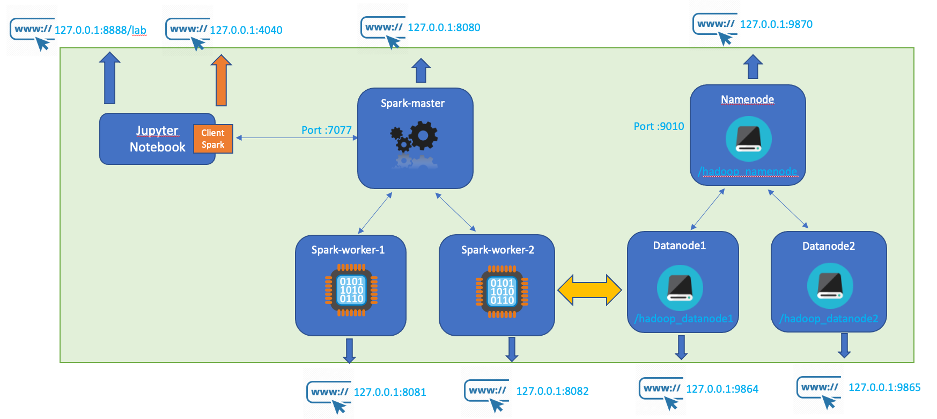


Pour les TP nous utiliserons différents jeux de données :
* appl_stock.csv : Des données relatives au prix de la pomme en bourse.
* sales_info.csv : Une liste des ventes réalisées entre entreprises.
* wash_dc_crime_incidents_2013 : Liste des crimes répertoriée à Washington en 2013

Ces 3 jeux de données sont inclus dans le container jupyter.
Merci de bien vouloir démarrer votre cluster HDFS et de copier les jeux de données que vous utiliserez pour les TP SPARK.


Démarrer le cluster SPARK :

Copier des fichiers de jeux de données en exécutant la cellule suivante :

In [ ]:
!$HADOOP_HOME/bin/hdfs dfs -mkdir -p /data/tpspark
!$HADOOP_HOME/bin/hdfs dfs -put /home/jovyan/data/sales_info.csv /data/tpspark/
!$HADOOP_HOME/bin/hdfs dfs -put /home/jovyan/data/wash_dc_crime_incidents_2013.csv /data/tpspark/
!$HADOOP_HOME/bin/hdfs dfs -put /home/jovyan/data/appl_stock.csv /data/tpspark/

On vérifie que les fichiers sont bien dans hdfs :

In [ ]:
!$HADOOP_HOME/bin/hdfs dfs -ls /data/tpspark

On peut à présent démarrer notre cluster Spark

Vérifiez que les containers smaster, sworker1 et sworker2 sont démarrés :


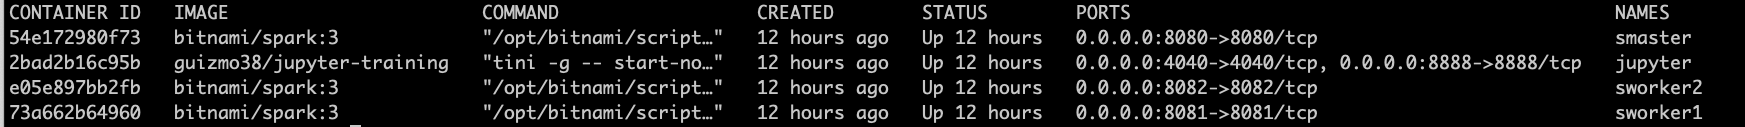

Dans la configuration actuelle de Spark, nous utilisons le gestionnaire de ressources ( Spark Standalone ) fournit nativement avec Spark. 

Une fois Spark démarré, vous aurez accés à l'interface du cluster Spark.

http://127.0.0.1:8080

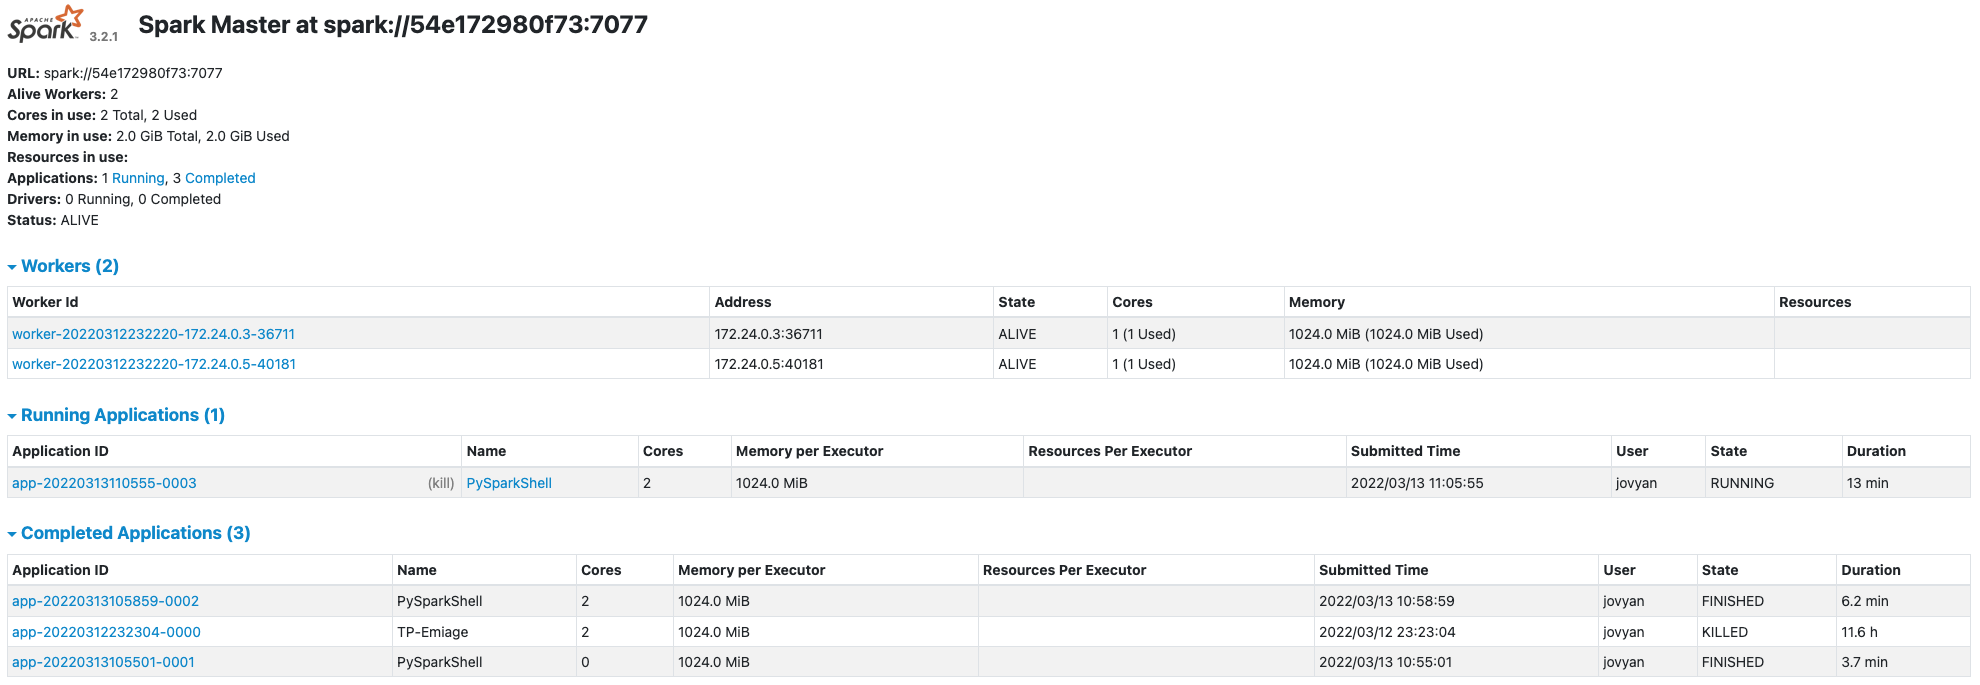

Dans l'interface graphique de Spark, nous trouverons une mine d'information sur la gestion des tâches et les plans d'exécution de Spark pour chaque traitement. Nous ne couvrirons pas dans ce cours l'interface mais nous allons plus nous intéresser à la soumission de tâche sur Spark.



<div class="alert alert-block alert-warning">
Attention, certains liens ne fonctionneront pas dans un environnement sous docker, vous devrez modifier manuellement les URLS des liens par 127.0.0.1
</div>

Avec Spark, il est possible de soumettre du code SCALA ou PYTHON de plusieurs manières :
* avec l'interpreteur spark pour du code en SCALA
* avec l'interpreteur pyspark pour du code en python
* par soumission de jobs (spark-submit)

Dans les TP, nous nous focaliserons uniquement sur pyspark et la soumission de jobs.

## Connexion à Spark via pyspark

Connectez vous au container "jupyter" via un terminal:


Utiliser l'interpreteur pyspark pour vous connecter à votre cluster spark:

Pour confirmer que vous êtes bien connecté, lancez la commande suivante :

La variable sc est par défaut celle utilisée par pyspark pour identifier l'objet de connexion à notre cluster Spark.

Vous pouvez à présent lancer un petit code qui traite une liste de valeur numérique et ajoute1 à chaque valeur :


Le driver Spark est le composant dont le rôle est d'optimiser la parallelisation des traitements sur l'ensemble des workers. L'avancement de tous les jobs ainsi que le niveau de parallélisme sont visibles sur l'interface graphique fournit avec le driver. Pour consulter ces informations vous pouvez consulter l'url suivante :
http://127.0.0.1:4040/jobs/

Rappel, le driver converti un traitement en tâche lesquelles sont ensuite transmises aux différents workers. Si vous ne soumettez pas de job, l'url n'affichera rien.

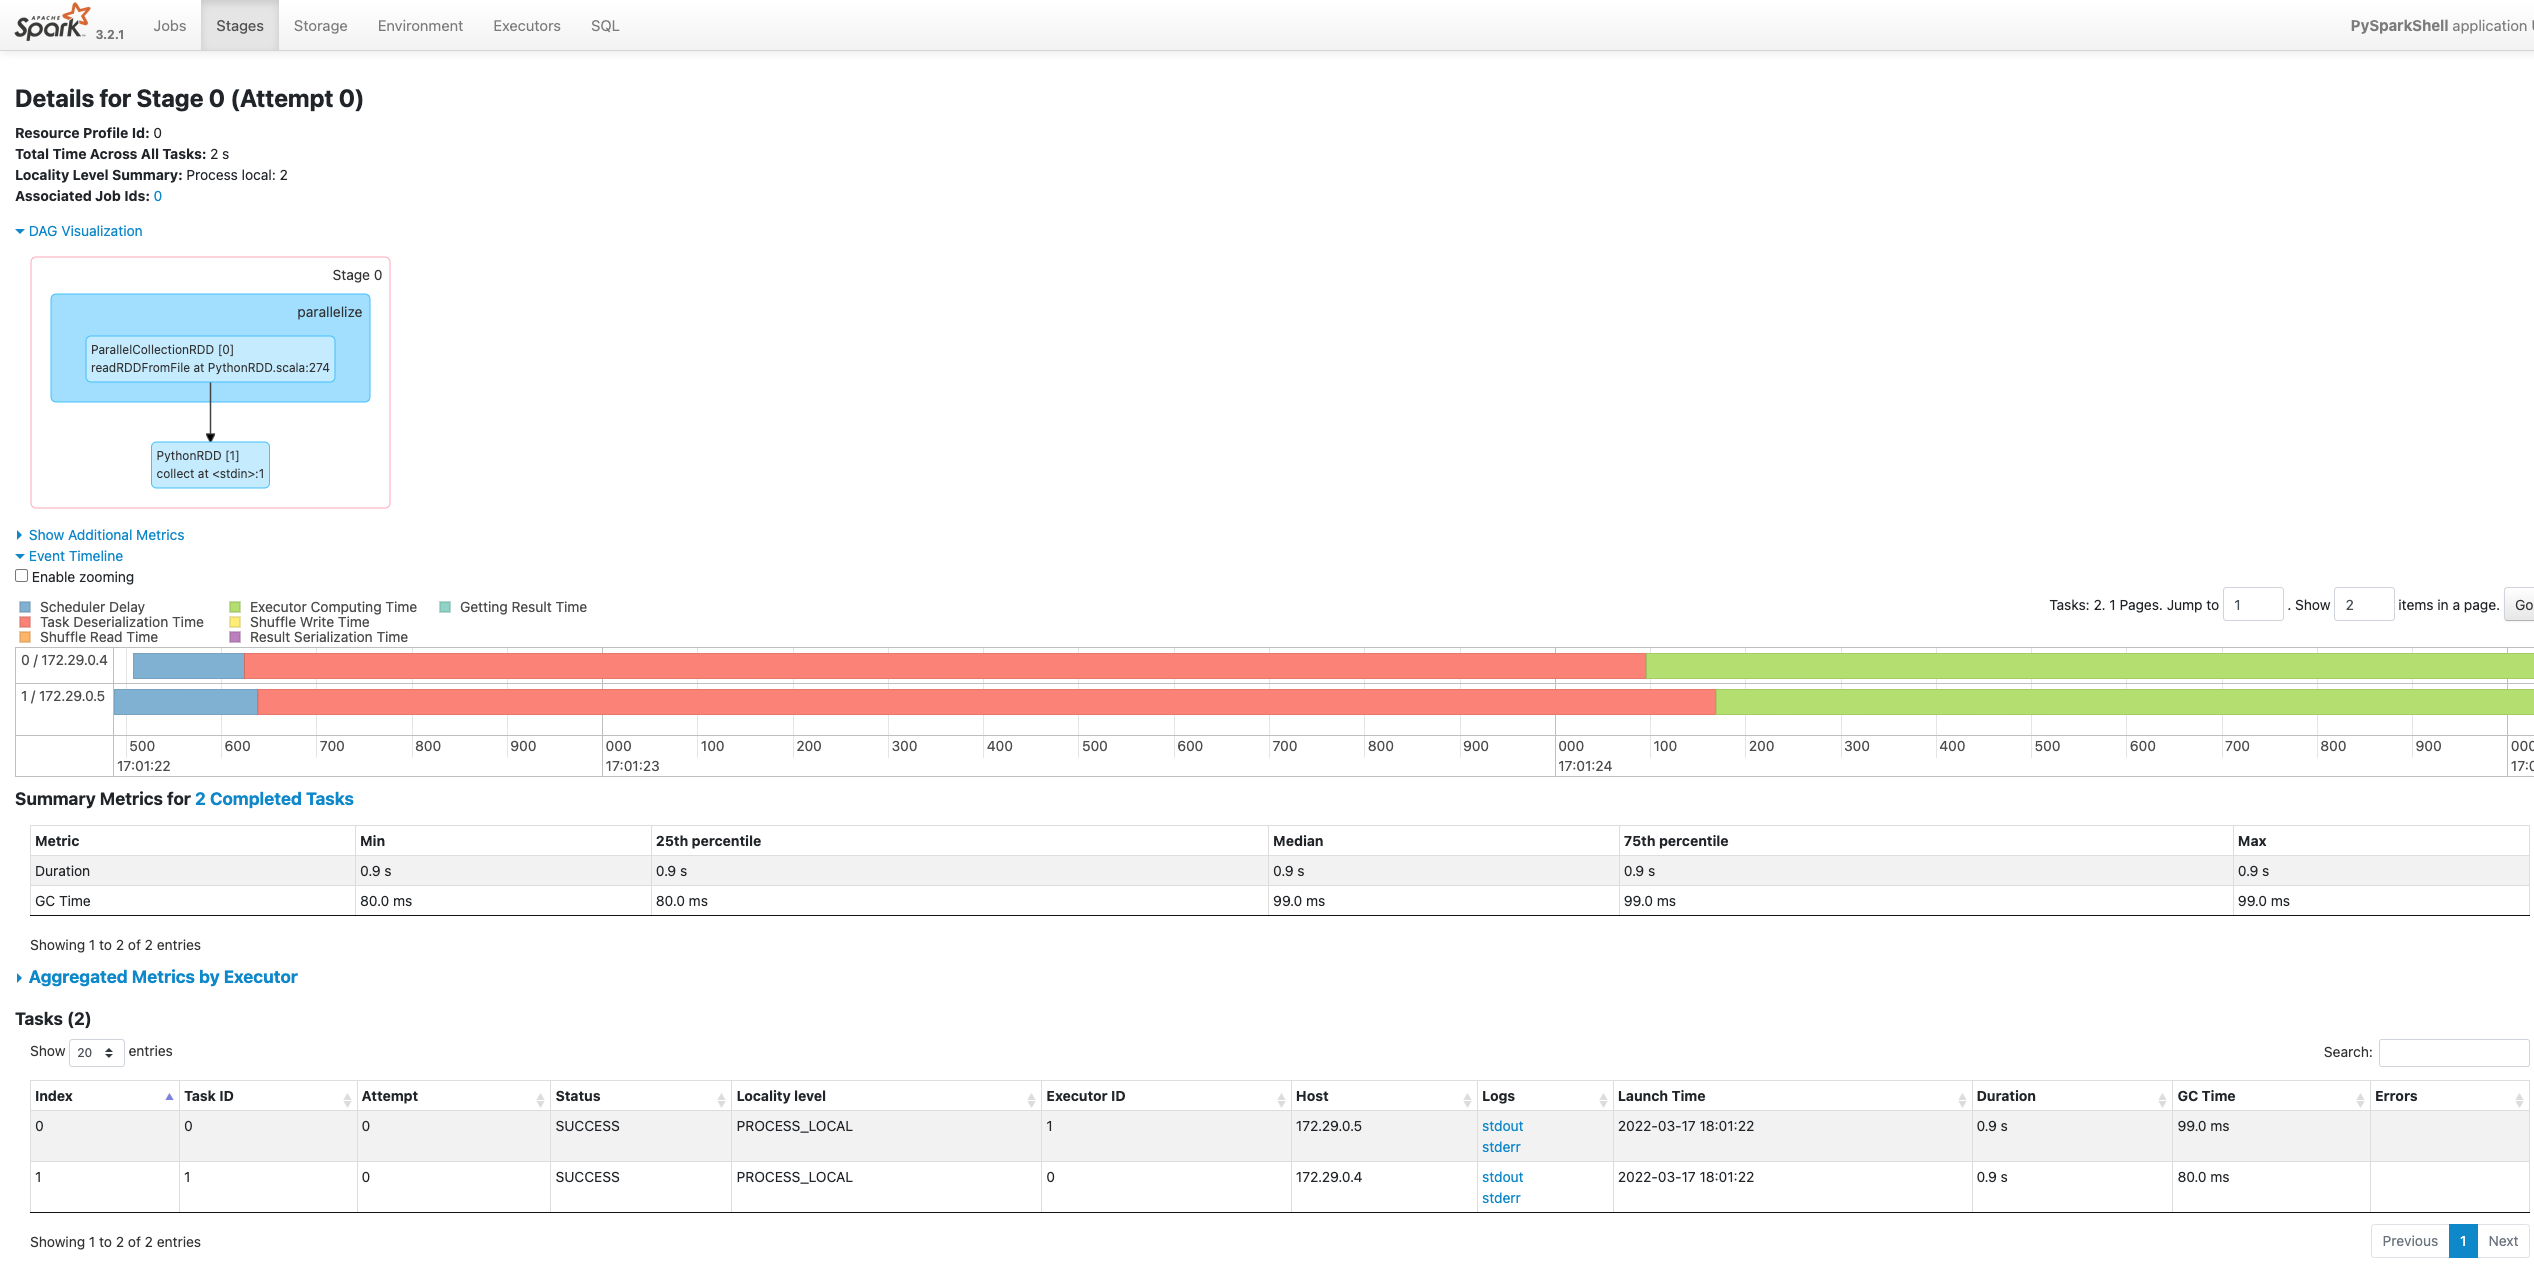

## Comment soumettre un job Spark

Tout au long des TPs, vous allez dans la plupart des cas utiliser le notebook comme interface.
Cependant, il faut savoir qu'il est possible de soumettre des jobs/ applications Spark via la commande spark-submit.

Spark-submit prend de nombreuses options lesquelles définissent l'environnement d'exécution du programme spark :
* le nombre d'executeur
* le nombre de CPU / RAM par executeur
* l'emplacement du driver
    * Le driver est contenairisé et dans ce cas le programme continue de s'exéuter même si le client qui a soumis le programme n'est plus joignable (mode cluster)
    * Le driver est sur une machine (mode client) qui communique avec le cluster et doit être accessible tout au long du traitement (mode par défaut).


    

Nous allons utiliser un petit programme Spark qui va compter le nombre de mots dans le fichier suivant : /datasets/wash_dc_crime_incidents_2013.csv

In [ ]:
with open('spark_program.py', 'w') as fh:
        fh.write("""#!/usr/bin/env python
from pyspark import SparkContext
from operator import add
# On peut définir les ressources à allouer au programme via le SparkContext
# Le SparkContext peut être configuré via les options de spark-submit soit dans le programme  
sc = SparkContext("spark://smaster:7077", "MonProgramme")
myRdd =  sc.textFile("/data/tpspark/wash_dc_crime_incidents_2013.csv")

result = myRdd.map(lambda x : ("rowcount",1)).reduceByKey(add).collect()
for r in result:
    print(r)
""")
!chmod a+x spark_program.py

On peut à présent soumettre notre programme :

Pour afficher les détails de la répartition des tâches, le niveau des traces a été mis à INFO et vous montrera le nombre de tâches distribuées soumis sur les workers.
Le résultat est quelque peu noyer sous les traces mais vous devriez voir apparaître le résultat suivant : ('rowcount', 35898) 

In [ ]:
!spark-submit --name 'Mon Programme Spark' spark_program.py